### پروژه نهایی داده کاوی
#### احمد ستوده 4001231058

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import silhouette_score


from sklearn.svm import SVC
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

#### Loading Dataset and Describe

In [58]:
data = pd.read_csv('modified_diabetes_prediction_dataset.csv')
data.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,99999.000000,100001.000000,100001.000000,100001.000000,100000.000000,100001.000000,100001.000000
mean,41.391930,0.074849,0.039420,27.318426,5.527523,138.155888,0.084999
std,22.669181,0.263149,0.194592,6.935843,1.070676,51.279018,0.278882
min,-4.920000,0.000000,0.000000,3.629572,3.500000,80.000000,0.000000
25%,23.000000,0.000000,0.000000,23.382033,4.800000,100.000000,0.000000
50%,42.000000,0.000000,0.000000,26.964724,5.800000,140.000000,0.000000
75%,59.000000,0.000000,0.000000,30.279663,6.200000,159.000000,0.000000
max,84.000000,1.000000,1.000000,101.665015,9.000000,9999.000000,1.000000


In [59]:
data.isna().sum()

gender                 0
age                    2
hypertension           0
heart_disease          0
smoking_history        1
bmi                    0
HbA1c_level            1
blood_glucose_level    0
diabetes               0
dtype: int64

### Fixing Null, Missing and inconsistent valuse

In [60]:
def fix_gender(row):
    if (pd.isna(row['gender'])) or (row['gender'] == 'unknown'):
        similar_class_mode = data[data['diabetes'] == row['diabetes']]['gender'].mode()[0]
        return similar_class_mode
    return row['gender']
data['gender'] = data.apply(fix_gender, axis=1)
data['gender'].unique()

array(['Female', 'Male', 'Other'], dtype=object)

In [61]:
data['smoking_history'] = data['smoking_history'].replace({
    'ever': 'never',
    'yes': 'current',
    'not current': 'former'
})

In [62]:
def handle_smoking_history(row):
    
    if pd.isna(row['smoking_history']) or row['smoking_history'] == 'No Info':
        if row['diabetes'] == 1:
            return positive_diabetes_smoke_mode
        if row['diabetes'] == 0:
            return negative_diabetes_smoke_mode
        
    return row['smoking_history']

negative_diabetes_smoke_mode = data[data['diabetes'] == 0]['smoking_history'].mode()[0]
positive_diabetes_smoke_mode = data[data['diabetes'] == 1]['smoking_history'].mode()[0]

data['smoking_history'] = data.apply(handle_smoking_history, axis=1)
data['smoking_history'].unique()

array(['never', 'current', 'former'], dtype=object)

In [63]:
def fill_with_mode_or_mean(row, column):
    if (pd.isna(row[column])) or (row[column] < 0):
        if column in ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']:
            return data[column].mean()
        return data[column].mode()[0]
    return row[column]

missing_columns = ['age', 'HbA1c_level']
for column in missing_columns:
    data[column] = data.apply(lambda row: fill_with_mode_or_mean(row, column), axis=1)

### Describe Data, Outlier Detection and Removal

In [64]:
data.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000
mean,42.060677,0.074849,0.039420,27.318426,5.527523,138.155888,0.084999
std,22.008467,0.263149,0.194592,6.935843,1.070671,51.279018,0.278882
min,0.000000,0.000000,0.000000,3.629572,3.500000,80.000000,0.000000
25%,24.000000,0.000000,0.000000,23.382033,4.800000,100.000000,0.000000
50%,42.000000,0.000000,0.000000,26.964724,5.800000,140.000000,0.000000
75%,59.000000,0.000000,0.000000,30.279663,6.200000,159.000000,0.000000
max,84.000000,1.000000,1.000000,101.665015,9.000000,9999.000000,1.000000


In [65]:
numeric_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
for col in numeric_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[col] = data[col].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)

### Scaling Numeric Columns

In [66]:
scaler = MinMaxScaler()
numeric_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

### Dropping Duplicate Rows

In [67]:
data = data.drop_duplicates()

### Fixing Inconsistent Cols (smoking_history and gender)

In [68]:
data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,0.928571,0,1,never,1.000000,0.645833,0.358209,0
1,Female,0.492761,0,0,never,0.543628,0.645833,0.000000,0
2,Male,0.333333,0,0,never,0.447022,0.458333,1.000000,0
3,Female,0.440476,0,0,current,0.443160,0.422401,0.447761,0
4,Male,0.892857,1,1,current,0.368867,0.270833,0.447761,0


In [69]:
data['smoking_history'].unique()

array(['never', 'current', 'former'], dtype=object)

In [70]:
gender_mapping = {
'Other': float(0/3),
'Female': float(1/3),
'Male': float(2/3),
}

data['gender'] = data['gender'].map(gender_mapping)

smoke_mapping = {
'never': float(0/3),
'former': float(1/3),
'current': float(2/3)
}

data['smoking_history'] = data['smoking_history'].map(smoke_mapping)

# Data is CLEAN now!

In [71]:
data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0.333333,0.928571,0,1,0.000000,1.000000,0.645833,0.358209,0
1,0.333333,0.492761,0,0,0.000000,0.543628,0.645833,0.000000,0
2,0.666667,0.333333,0,0,0.000000,0.447022,0.458333,1.000000,0
3,0.333333,0.440476,0,0,0.666667,0.443160,0.422401,0.447761,0
4,0.666667,0.892857,1,1,0.666667,0.368867,0.270833,0.447761,0


### Checking Correlation:

In [72]:
data.corr()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
gender,1.000000,-0.024161,0.014435,0.077795,0.041424,-0.012110,0.019606,0.015987,0.037990
age,-0.024161,1.000000,0.247943,0.232666,0.139771,0.319324,0.094255,0.100962,0.253951
hypertension,0.014435,0.247943,1.000000,0.121246,0.054337,0.145190,0.077715,0.078098,0.197878
heart_disease,0.077795,0.232666,0.121246,1.000000,0.052982,0.064395,0.064744,0.064474,0.171883
smoking_history,0.041424,0.139771,0.054337,0.052982,1.000000,0.118100,0.024767,0.030163,0.069998
bmi,-0.012110,0.319324,0.145190,0.064395,0.118100,1.000000,0.076951,0.080054,0.202033
HbA1c_level,0.019606,0.094255,0.077715,0.064744,0.024767,0.076951,1.000000,0.147453,0.384778
blood_glucose_level,0.015987,0.100962,0.078098,0.064474,0.030163,0.080054,0.147453,1.000000,0.386430
diabetes,0.037990,0.253951,0.197878,0.171883,0.069998,0.202033,0.384778,0.386430,1.000000


### Dropping uncorrelated cols (smoking_history and gender)

In [73]:
data = data.drop(columns=['gender', 'smoking_history'])

### Splitting Data

In [74]:
X = data.drop(columns=['diabetes'])
y = data['diabetes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

## Training and Evaluation of Classifiers (DT, SVM)

In [75]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

Decision Tree Results:
Accuracy: 0.95
Precision: 0.72
Recall: 0.74
F1-Score: 0.73



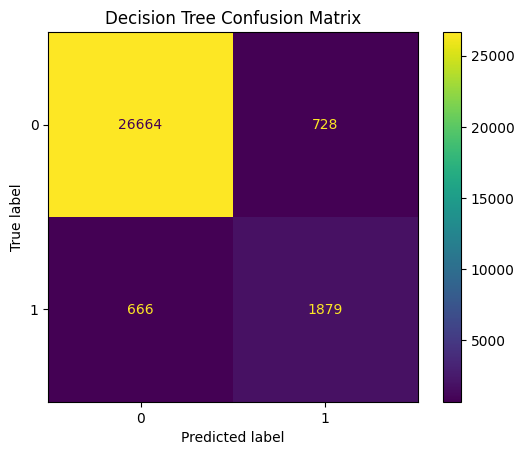

In [76]:
acc = accuracy_score(y_test, y_pred_dt)
prec = precision_score(y_test, y_pred_dt, average='binary')
rec = recall_score(y_test, y_pred_dt, average='binary')
f1 = f1_score(y_test, y_pred_dt, average='binary')

print(f"Decision Tree Results:")
print(f"Accuracy: {acc:.2f}")
print(f"Precision: {prec:.2f}")
print(f"Recall: {rec:.2f}")
print(f"F1-Score: {f1:.2f}\n")

cm = confusion_matrix(y_test, y_pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title(f"Decision Tree Confusion Matrix")
plt.show()

In [77]:
svm = SVC(kernel='poly', random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

SVM Results:
Accuracy: 0.96
Precision: 0.98
Recall: 0.59
F1-Score: 0.74



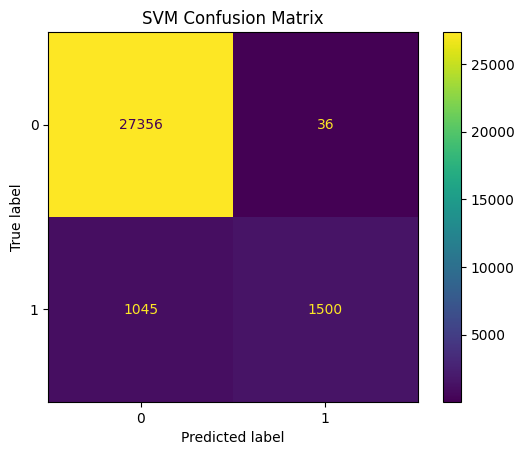

In [78]:
acc = accuracy_score(y_test, y_pred_svm)
prec = precision_score(y_test, y_pred_svm, average='binary')
rec = recall_score(y_test, y_pred_svm, average='binary')
f1 = f1_score(y_test, y_pred_svm, average='binary')

print(f"SVM Results:")
print(f"Accuracy: {acc:.2f}")
print(f"Precision: {prec:.2f}")
print(f"Recall: {rec:.2f}")
print(f"F1-Score: {f1:.2f}\n")

cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title(f"SVM Confusion Matrix")
plt.show()

## Training and Evaluation of Clustering Models (KMeans, Hirearchical, DBSCAN)

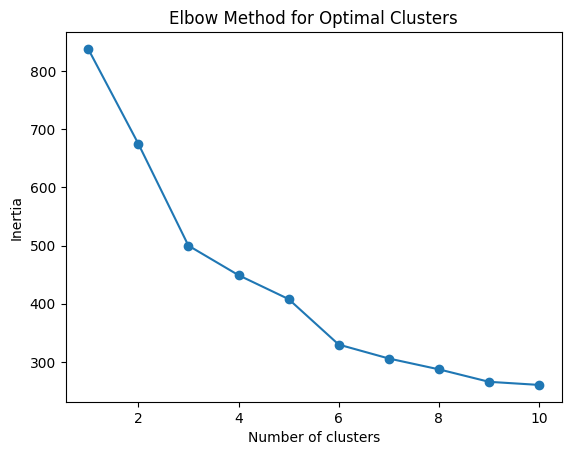

In [79]:
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train[:2500])
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Clusters')
plt.show()

In [80]:
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
labels_kmeans = kmeans.fit_predict(X_train[:10000])
print(f"Silhouette Score for KMeans: {silhouette_score(X_train[:10000], labels_kmeans):.2f}\n")

Silhouette Score for KMeans: 0.21



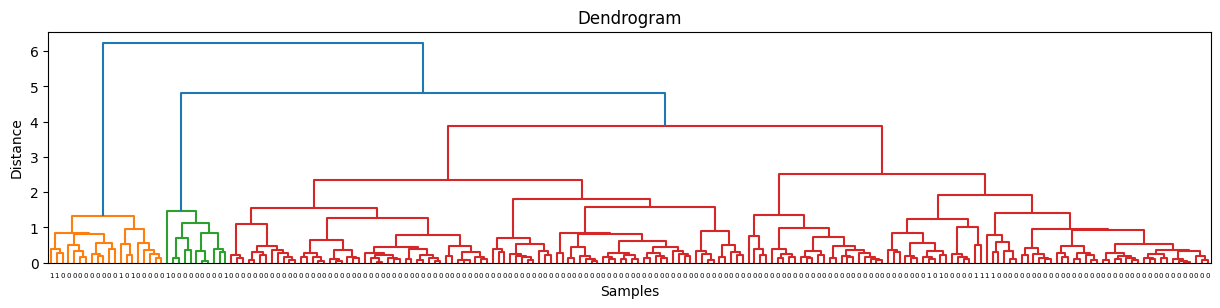

In [81]:
dendro = linkage(X_train[:200], method='ward')
plt.figure(figsize=(15,3))
dendrogram(dendro, labels=y_train[:200].values)
plt.title('Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.xticks(rotation=0)
plt.show()

In [82]:
dendro = linkage(X_train[:10000], method='ward')

threshold = 10
labels_hierarchical = fcluster(dendro, t=threshold, criterion='distance')
print(f"Silhouette Score for Hierarchical Clustering: {silhouette_score(X_train[:10000], labels_hierarchical):.2f}\n")

Silhouette Score for Hierarchical Clustering: 0.22



In [83]:
dbscan = DBSCAN(eps=0.5, min_samples=10)
labels_dbscan = dbscan.fit_predict(X_train[:10000])
print(f"Silhouette Score for DBSCAN: {silhouette_score(X_train[:10000], labels_dbscan):.2f}\n")

Silhouette Score for DBSCAN: 0.50

